# Rose tutorial numerical model


In [1]:
import sys
sys.path.append(r"../") # go to parent dir

In [2]:
import os

# import pickle for saving results
import pickle
# import ROSE packages
import rose.model
from run_rose.read_wolf import read_wolf
from rose.model.model_part import Material, Section
from rose.model.train_model import *
from rose.model.train_track_interaction import *

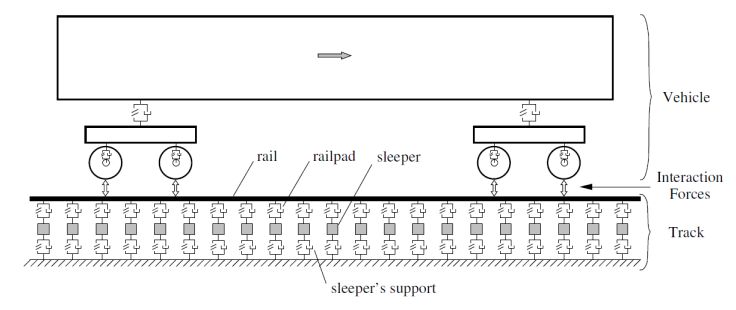

# Fill in parameters train

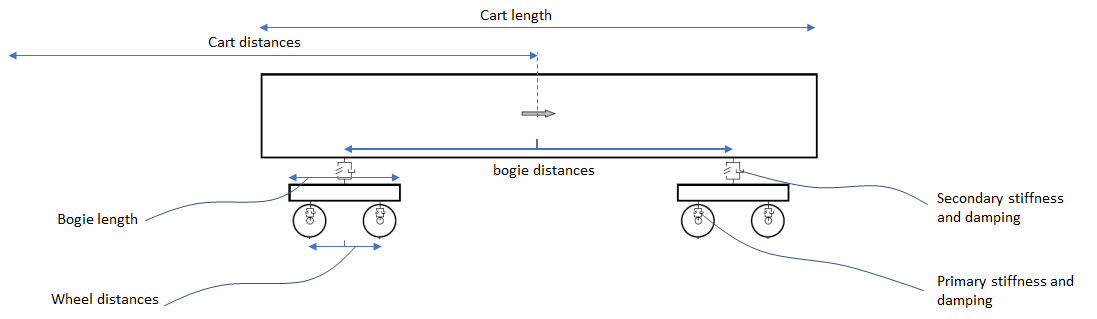

## Custom train

Set up a custom train


In [3]:

# set up train
tr = {}

start_coord = 10
velocity = 120/3.6 # set velocity of the train [m/s]


# set up bogie configuration
tr["wheel_distances"] = [-1.25, 1.25]  # wheel distances from the centre of the bogie [m]
tr["bogie_length"] = 2  # length of the bogie [m]

# set up cart configuration
tr["bogie_distances"] = [-10, 10]  # bogie distances from the centre of the cart [m]
tr["cart_length"] = 28  # length of the cart [m]

# set up train configuration
tr["cart_distances"] = [start_coord]  # cart distances from the start of the track [m]

# set train parameters
tr["mass_wheel"] = 1834/2  # mass of one wheel [kg]
tr["mass_bogie"] = 6e3/2  # mass of one bogie [kg]
tr["mass_cart"] = 75.5e3/2  # mass of one cart  [kg]

tr["inertia_bogie"] = 0.31e3/2  # mass inertia of one bogie   [kg.m2]
tr["inertia_cart"] = 128.8e3/2  # mass inertia of one cart   [kg.m2]

tr["prim_stiffness"] = 4800e3/2  # primary suspension: stiffness between wheels and bogie  [N/m]
tr["sec_stiffness"] = 2708e3/2  # secondary suspension: stiffness between bogies and cart  [N/m]

tr["prim_damping"] = 0.25e3/2  # primary suspension: damping between wheels and bogie  [N.s/m]
tr["sec_damping"] = 64e3/2  # secondary suspension: damping between bogies and cart  [N.s/m]

tr["velocity"] = velocity # set velocity of the train [m/s]

# set default train is chosen on false, for further generation within the notebook
default_train_is_chosen = False

## Default train

Alternatively, a default train can be chosen, comment the following section out if you want to maintain the custom parameters


In [4]:
from rose.pre_process import default_trains

# set train type
train_type = default_trains.TrainType.SPRINTER_SLT

# create train model
train = default_trains.set_train(0,0,start_coord,train_type)

# set default train is chosen on true, for further generation within the notebook
default_train_is_chosen = True

# Set geometry track

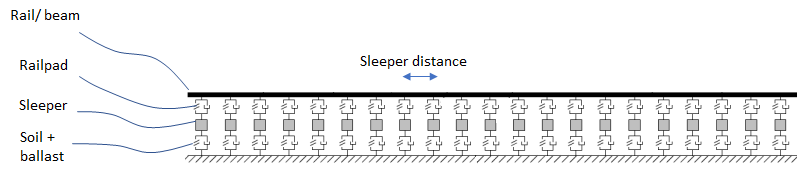


In this part of the code, the geometry of the track is set. It is possible to divide the track in multiple segment with a different underlying soil stiffness, thus modeling a stiffness transition is possible. The segment dependent track parameters are always defined in a list, also when only 1 segment is desired.

In [5]:
# Set geometry parameters of the track

# set number of sleepers per segment. Any amount of segments can be chosen. Each segment can have a different soil stiffness
nb_sleepers_per_segment =[100,100]
geometry = {}
geometry["n_segments"] = len(nb_sleepers_per_segment)  # number of segments
geometry["n_sleepers"] = [n  for n in nb_sleepers_per_segment]  # number of sleepers per segment
geometry["sleeper_distance"] = 0.6  # distance between sleepers, equal for each segment
geometry["depth_soil"] = [1.0  for n in nb_sleepers_per_segment]  # depth of the soil [m] per segment  

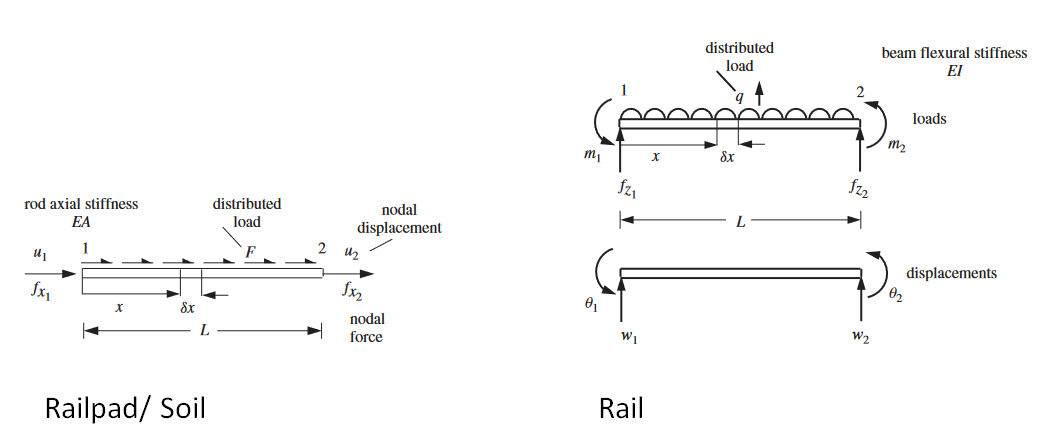

# Fill in parameters track

Below the parameters of the track are to be filled in. Note that the soil parameters are to be given per segment, these parameters are always to be given in a list. If 2 segments are present, 2 stiffnessess and 2 dampings are to be filled in.

In [6]:
mat = {}
# set parameters of the rail
mat["young_mod_beam"] = 210e9  # young modulus rail [N/m]
mat["poisson_beam"] = 0.0  # poison ration rail
mat["inertia_beam"] = 2.3379E-05  # inertia of the rail [m4]
mat["rho"] = 7860  # density of the rail [kg/m3]
mat["rail_area"] = 69.77e-4  # area of the rail [m]
mat["shear_factor_rail"] = 0  # Timoshenko shear factor
mat["height_rail"] = 0.159 # height of the rail section [m]
mat["height_neutral_axis"] = 0.0699 # height of the neutral axis of the rail [m]

# set parameters rail pad
mat["mass_rail_pad"] = 5  # mass of the rail pad [kg]
mat["stiffness_rail_pad"] = 800e6  # stiffness of the rail pad [N/m2]
mat["damping_rail_pad"] = 800e3  # damping of the rail pad [N/m2/s]

# set parameters sleeper
mat["mass_sleeper"] = 142.5  # [kg]

# Rayleigh damping system
mat["damping_ratio"] = 0.002  # damping
mat["omega_one"] = 6.283  # first radial_frequency
mat["omega_two"] = 125.66  # second radial_frequency

# set up contact parameters
mat["hertzian_contact_coef"] = 9.1e-8  # Hertzian contact coefficient
mat["hertzian_power"] = 3 / 2  # Hertzian power

# Set soil parameters of each segment
soil = {"stiffness_soils": [180e7,180e6], # stiffness of the soil [N/m2]
        "damping_soils": [30e3, 30e3]}    # dampng of the soil [N/m2/s]


# Fill in time integration

In [7]:
time_int = {}
# set time parameters in two stages
time_int["tot_ini_time"] = 0.5  # total initalisation time  [s]
time_int["n_t_ini"] = 5000  # number of time steps initialisation time  [-]

time_int["tot_calc_time"] = 2.5  # total time during calculation phase   [s]
time_int["n_t_calc"] = 25000  # number of time steps during calculation phase [-]


# Choose solver

Below, the solver for the calculation is set. Generally the "NewmarkExplicit" solver is faster, while the "NewmarkImplicitForce" solver is more stable, thus requiring less time steps.  

In [8]:
# choose solver
from solvers.newmark_solver import NewmarkExplicit, NewmarkImplicitForce
solver = NewmarkImplicitForce()


# Populate time integration

In [9]:
# set initialisation time
initialisation_time = np.linspace(0, time_int["tot_ini_time"], time_int["n_t_ini"])
# set calculation time
calculation_time = np.linspace(initialisation_time[-1], initialisation_time[-1] + time_int["tot_calc_time"],
                               time_int["n_t_calc"])
# Combine all time steps in an array
time = np.concatenate((initialisation_time, calculation_time[1:]))

# Generate geometry track

In [10]:
all_element_model_parts = []
all_meshes = []
# loop over number of segments
for idx in range(geometry["n_segments"]):
    # set geometry of one segment
    element_model_parts, mesh = create_horizontal_track(geometry["n_sleepers"][idx],
                                                        geometry["sleeper_distance"],
                                                        geometry["depth_soil"][idx])
    # add segment model parts and mesh to list
    all_element_model_parts.append(element_model_parts)
    all_meshes.append(mesh)

# Setup global mesh and combine model parts of all segments
rail_model_part, sleeper_model_part, rail_pad_model_part, soil_model_parts, all_mesh = \
    combine_horizontal_tracks(all_element_model_parts, all_meshes, geometry["sleeper_distance"])

# Fixate the bottom boundary
bottom_boundaries = [add_no_displacement_boundary_to_bottom(soil_model_part)["bottom_boundary"] for soil_model_part
                     in soil_model_parts]

# constraint rotation at the side boundaries
side_boundaries = ConstraintModelPart(x_disp_dof=False, y_disp_dof=True, z_rot_dof=True)
side_boundaries.nodes = [rail_model_part.nodes[0], rail_model_part.nodes[-1]]


# Populate train model

In [11]:
# set velocity of train
velocities = np.ones(len(time)) * tr["velocity"]

# prevent train from moving in initialisation phase
velocities[0:len(initialisation_time)] = 0   

# set up train
if not default_train_is_chosen:
    train = TrainModel()

    # set up carts
    train.cart_distances = tr["cart_distances"]
    train.carts = [Cart() for idx in range(len(tr["cart_distances"]))]
    for cart in train.carts:
        cart.bogie_distances = tr["bogie_distances"]
        cart.inertia = tr["inertia_cart"]
        cart.mass = tr["mass_cart"]
        cart.stiffness = tr["sec_stiffness"]
        cart.damping = tr["sec_damping"]
        cart.length = tr["cart_length"]

        # setup bogies per cart
        cart.bogies = [Bogie() for idx in range(len(tr["bogie_distances"]))]
        for bogie in cart.bogies:
            bogie.wheel_distances = tr["wheel_distances"]
            bogie.mass = tr["mass_bogie"]
            bogie.inertia = tr["inertia_bogie"]
            bogie.stiffness = tr["prim_stiffness"]
            bogie.damping = tr["prim_damping"]
            bogie.length = tr["bogie_length"]

            # setup wheels per bogie
            bogie.wheels = [Wheel() for idx in range(len(tr["wheel_distances"]))]
            for wheel in bogie.wheels:
                wheel.mass = tr["mass_wheel"]    
                
train.use_irregularities = True
train.time = time
train.velocities = velocities

## Define irregularities

In this example, the front wheel contains a wheel flat, therefore a custom irregularities array is defined

### Initialise train movement 

Firstly initialise the train parts, i.e. wheels, bogies and carts. Note that this is only required when applying a custom 
irregularities matrix

In [12]:
# calculate distances of the train over time
train.calculate_distances()

# set mesh of the train
train.set_mesh()

# make train parts easily accessible 
train.get_train_parts()


In [13]:
from rose.model.irregularities import WheelFlat
# firstly initialise irregularites array as a zeros matrix
irregularities = np.zeros((len(train.wheels), len(train.time)))

### Define irregularities matrix

Below a wheel flat in 1 wheel is simulated

In [14]:
# the front wheel is the last wheel in the wheels array
wheel_index = -1 # -1 indicates the last wheel
front_wheel = train.wheels[wheel_index]

# the wheel flat is defined as a function of distance traveled and the circumference of the wheel
wheel_diameter = 0.92 # wheel diameter[m]
wheel_flatness_length = 0.04 # length of the wheel is flat [m]

# calculate wheel flat array
wheel_flat = WheelFlat(front_wheel.distances, wheel_diameter, wheel_flatness_length)
wheel_flat_array = wheel_flat.irregularities

# add wheel flat array to the train irregularities matrix
irregularities[wheel_index,:] = wheel_flat_array


In [15]:
train.irregularities_at_wheels = irregularities

# Populate track model

In [16]:
# set elements
material = Material()
material.youngs_modulus = mat["young_mod_beam"]
material.poisson_ratio = mat["poisson_beam"]
material.density = mat["rho"]

section = Section()
section.area = mat["rail_area"]
section.sec_moment_of_inertia = mat["inertia_beam"]
section.shear_factor = mat["shear_factor_rail"]
section.height = mat["height_rail"]
section.height_neutral_axis = mat["height_neutral_axis"]

rail_model_part.section = section
rail_model_part.material = material

rail_pad_model_part.mass = mat["mass_rail_pad"]
rail_pad_model_part.stiffness = mat["stiffness_rail_pad"]
rail_pad_model_part.damping = mat["damping_rail_pad"]

sleeper_model_part.mass = mat["mass_sleeper"]

for idx, soil_model_part in enumerate(soil_model_parts):
    soil_model_part.stiffness = soil["stiffness_soils"][idx]
    soil_model_part.damping = soil["damping_soils"][idx]


# populate global system
track = GlobalSystem()
track.mesh = all_mesh
track.time = time

# collect all model parts track
model_parts = [rail_model_part, rail_pad_model_part, sleeper_model_part, side_boundaries] \
              + soil_model_parts + bottom_boundaries
track.model_parts = model_parts


In [17]:
track.model_parts

# Populate train track interaction model

In [18]:
# setup coupled train track system
coupled_model = CoupledTrainTrack()

coupled_model.train = train
coupled_model.track = track
coupled_model.rail = rail_model_part
coupled_model.time = time
coupled_model.initialisation_time = initialisation_time

coupled_model.hertzian_contact_coef = mat["hertzian_contact_coef"]
coupled_model.hertzian_power = mat["hertzian_power"]

coupled_model.solver = solver

coupled_model.is_rayleigh_damping = True
coupled_model.damping_ratio = mat["damping_ratio"]
coupled_model.radial_frequency_one = mat["omega_one"]
coupled_model.radial_frequency_two = mat["omega_two"]

# Calculate

$F = M \cdot a + C \cdot v + K \cdot u$

In [19]:
coupled_model.main()

Initialising train
Initialising track and subsoil
Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.00/2.00 [00:00<00:00, 505steps/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00/1.00 [00:00<00:00, 661steps/s]

Initial static displacement of the train and the track



  0%|                                                                                                                       | 0.00/5.00k [00:00<?, ?steps/s]

Calculating calculation phase


..\rose\model\train_track_interaction.py:189: RuntimeWarning: invalid value encountered in power
  np.nan_to_num(np.power(1 / self.hertzian_contact_coef * (elastic_wheel_deformation - du_wheels)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.00k/5.00k [00:11<00:00, 439steps/s]
  0%|▏                                                                                                                | 44.0/25.0k [00:00<01:54, 218steps/s]

Calculating calculation phase


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25.0k/25.0k [01:23<00:00, 298steps/s]


Finalising calculation


# Write results in a pickle file

First check which model parts are present in the model and at which position in the model part list, the model parts are located

In [20]:
coupled_model.track.model_parts


soil_indices = []

for idx, model_part in enumerate(coupled_model.track.model_parts):
    if isinstance(model_part,rose.model.track.Rail):
        rail_index = idx    
    if isinstance(model_part,rose.model.track.RailPad):
        rail_pad_index = idx 
    if isinstance(model_part,rose.model.track.Sleeper):
        sleeper_index = idx
    if isinstance(model_part,rose.model.soil.Soil):
        soil_indices.append(idx)

     


Now write the results from the coupled_model to a pickle file. Take good care of the model part index which is written to the output file, as this depends on the amount of segments in the model. Results are stored in a [Node/Element $*$ Time] List.

In [21]:
# name output directory
output_name = "tutorial_calculate_strain"
output_dir = "res"
output_interval = 1 # this indicates the interval of the output indices which should be written to the output file

# check if output folder exists, create if the directory does not exist
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

# collect results

track_model_parts = coupled_model.track.model_parts

# collect coordinates, vertical displacement and force of the rail

# set index of the rail model part
vertical_displacements_rail = np.array(
    [node.displacements[0::output_interval, 1] for node in track_model_parts[rail_index].nodes])
vertical_force_rail = np.array(
    [element.force[0::output_interval, 1] for element in track_model_parts[rail_index].elements])
coords_rail = np.array([node.coordinates[0] for node in track_model_parts[rail_index].nodes])

# collect coordinates, vertical displacement and force of the rail pad
vertical_displacements_rail_pad = np.array(
    [node.displacements[0::output_interval, 1] for node in track_model_parts[rail_pad_index].nodes])
vertical_force_rail_pad = np.array(
    [element.force[0::output_interval, 1] for element in track_model_parts[rail_pad_index].elements])
coords_rail_pad = np.array([node.coordinates[0] for node in track_model_parts[rail_pad_index].nodes])

# collect coordinates, vertical displacement and force of the sleepers
vertical_displacements_sleeper = np.array(
    [node.displacements[0::output_interval, 1] for node in track_model_parts[sleeper_index].nodes])
vertical_force_sleeper = np.array(
    [node.force[0::output_interval, 1] for node in track_model_parts[sleeper_index].nodes])
coords_sleeper = np.array([node.coordinates[0] for node in track_model_parts[sleeper_index].nodes])

# combine soil results
soil_nodes = []
soil_elements = []
for soil_index in soil_indices:
    soil_nodes.append(track_model_parts[soil_index].nodes)
    soil_elements.append(track_model_parts[soil_index].elements)
soil_nodes = list(itertools.chain.from_iterable(soil_nodes))
soil_elements = list(itertools.chain.from_iterable(soil_elements))


# collect coordinates, vertical displacement and force of the soil
vertical_displacements_soil = np.array(
    [node.displacements[0::output_interval, 1] for node in soil_nodes])
vertical_force_soil = np.array(
    [element.force[0::output_interval, 0] for element in soil_elements])
coords_soil = np.array([node.coordinates[0] for node in soil_nodes])


# collect vertical displacements and forces in train
vertical_displacements_train = np.array(
    [node.displacements[0::output_interval, 1] for node in coupled_model.train.nodes])
vertical_force_train = np.array([node.force[0::output_interval, 1] for node in coupled_model.train.nodes])

result_track = {"name": output_name,
                "time": coupled_model.time[0::output_interval].tolist(),
                "velocity": coupled_model.train.velocities[0::output_interval].tolist(),
                "vert_disp_rail": vertical_displacements_rail.tolist(),
                "vert_force_rail": vertical_force_rail.tolist(),
                "coords_rail": coords_rail.tolist(),
                "vertical_displacements_rail_pad": vertical_displacements_rail_pad.tolist(),
                "vertical_force_rail_pad": vertical_force_rail_pad.tolist(),
                "coords_rail_pad": coords_rail_pad.tolist(),
                "vertical_displacements_sleeper": vertical_displacements_sleeper.tolist(),
                "vertical_force_sleeper": vertical_force_sleeper.tolist(),
                "coords_sleeper": coords_sleeper.tolist(),
                "vertical_displacements_soil": vertical_displacements_soil.tolist(),
                "vertical_force_soil": vertical_force_soil.tolist(),
                "coords_soil": coords_soil.tolist(),
                "vertical_displacements_train": vertical_displacements_train.tolist(),
                "vertical_force_train": vertical_force_train.tolist(),
                }


# filename
file_name = f'res_{output_name}.pickle'
# dump pickle
with open(os.path.join(output_dir, file_name), "wb") as f:
    pickle.dump(result_track, f)

# dump all results in pickle, for later use
all_results_fn = f'all_results_{output_name}.pickle'
with open(os.path.join(output_dir, all_results_fn), "wb") as f:
    pickle.dump({"coupled_model":coupled_model}, f)

# Load results

In [22]:
import matplotlib.pyplot as plt

with open(os.path.join(output_dir, file_name), 'rb') as f:
    res_numerical = pickle.load(f)
    
with open(os.path.join(output_dir, all_results_fn), 'rb') as f:
    all_results = pickle.load(f)
    
res_coupled_model = all_results["coupled_model"]
    

In [23]:
res_coupled_model

## Retrieve results from dictionary

In [24]:
# define first output time index of calculation phase (Note that this might not be the same as the time index which is
# used during the calculation), this includes the output interval.
first_calc_t_idx = 5000

In [25]:
# Get displacement of each node of the train in the calculation phase
disp_train = np.array(res_numerical['vertical_displacements_train'])[:,first_calc_t_idx:]

# Get displacement of each node of the train in the calculation phase
vert_force_train = np.array(res_numerical['vertical_force_train'])[:,first_calc_t_idx:]

# get calculation time
time = np.array(res_numerical['time'])[first_calc_t_idx:]

# define delta time
dt = np.diff(time)

# get velocity in the calculation phase
velocity = np.array(res_numerical['velocity'])[first_calc_t_idx:]

# determine traveled distance
distance = np.insert(np.cumsum(dt*velocity[1:]),0,0)

# get vertical displacement in the soil during calculation phase
vertical_displacements_soil = np.array(res_numerical['vertical_displacements_soil'])[:,first_calc_t_idx:]

# get vertical force in the soil during calculation phase
vertical_force_soil = np.array(res_numerical['vertical_force_soil'])[:,first_calc_t_idx:]

# get vertical force in the rail during calculation phase
vertical_force_rail = np.array(res_numerical['vert_force_rail'])[:,first_calc_t_idx:]

# get vertical displacements of the rail during calculation phase
vertical_displacements_rail = np.array(res_numerical['vert_disp_rail'])[:,first_calc_t_idx:]

# get vertical displacements of the sleepers during calculation phase
vertical_displacement_sleepers = np.array(res_numerical['vertical_displacements_sleeper'])[:,first_calc_t_idx:]

# get vertical force of the sleepers during calculation phase
vertical_force_sleepers = np.array(res_numerical['vertical_force_sleeper'])[:,first_calc_t_idx:]


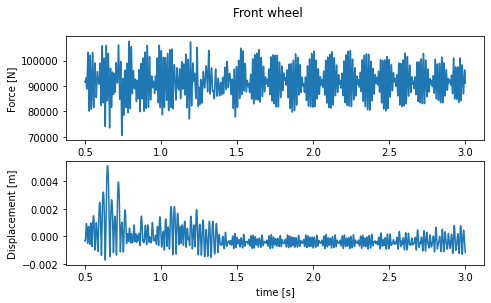

In [26]:
# plot vertical force and displacement of the front wheel 
fig, (ax1, ax2) = plt.subplots(2)

ax1.plot(time[:], vert_force_train[-1, :])
ax2.plot(time[:], disp_train[-1, :])

ax1.set_xlabel('time [s]')
ax1.set_ylabel('Force [N]')

ax2.set_xlabel('time [s]')
ax2.set_ylabel('Displacement [m]')

fig.set_size_inches(7.5, 4.2)
fig.suptitle('Front wheel')
plt.show()

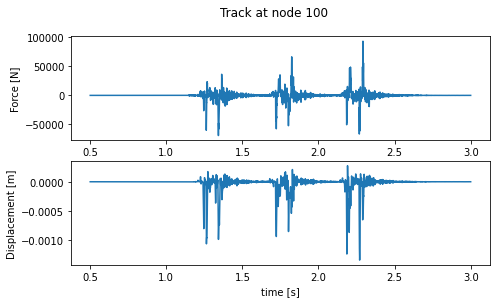

In [27]:
# plot vertical force and displacement of the rail at one node
fig, (ax1, ax2) = plt.subplots(2)

rail_node_nbr = 100
ax1.plot(time[:], vertical_force_rail[rail_node_nbr, :])
ax2.plot(time[:], vertical_displacements_rail[rail_node_nbr, :])

ax1.set_xlabel('time [s]')
ax1.set_ylabel('Force [N]')

ax2.set_xlabel('time [s]')
ax2.set_ylabel('Displacement [m]')

fig.set_size_inches(7.5, 4.2)
fig.suptitle(f'Track at node {rail_node_nbr}')
plt.show()

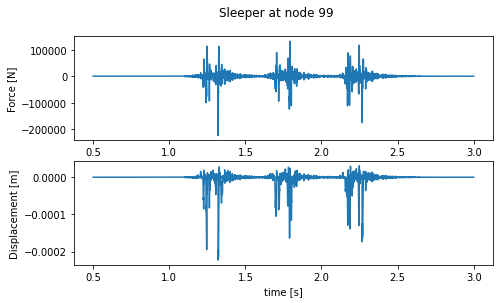

In [28]:

# plot vertical force and displacement of a sleeper
fig, (ax1, ax2) = plt.subplots(2)

sleeper_node_nbr = 99
ax1.plot(time[:], vertical_force_sleepers[sleeper_node_nbr, :])
ax2.plot(time[:], vertical_displacement_sleepers[sleeper_node_nbr, :])

ax1.set_xlabel('time [s]')
ax1.set_ylabel('Force [N]')

ax2.set_xlabel('time [s]')
ax2.set_ylabel('Displacement [m]')

fig.set_size_inches(7.5, 4.2)
fig.suptitle(f'Sleeper at node {sleeper_node_nbr}')
plt.show()

## Calculate strain in rail

Strain in the rail is calculated per element and per time step. In order to calculate the strain at a certain point, the correct rail element and the correct timestep has to be selected. 

In [29]:

# set distance from sleeper of the strain to be calculated
strain_distance=0.2

# get rail element, note that the rail elements are sorted from left to right. 
element_index = 99

rail_element = rail_model_part.elements[element_index]

# get rail modelpart
rail_model_part = coupled_model.track.model_parts[rail_index]

# get degree of freedom indices of element
dof_indices = []
for node in rail_element.nodes:
    dof_indices.extend(node.index_dof)

# get displacement of rail element at each time step
displacements_rail_element = coupled_model.solver.u[:,dof_indices]


strains = []
for t_index, t in enumerate(coupled_model.time):
    strains.append(rail_model_part.calculate_strain(strain_distance, displacements_rail_element[t_index,:]))
    



## Plot strain


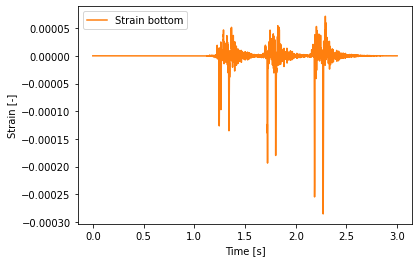

In [30]:
strains_np = np.array(strains)
strains_np
strains_bot = strains_np[:,1]


plt.plot(coupled_model.time, strains_bot,color="#ff7f0e")

plt.xlabel('Time [s]')
plt.ylabel('Strain [-]')
plt.legend([ 'Strain bottom'])
plt.show()

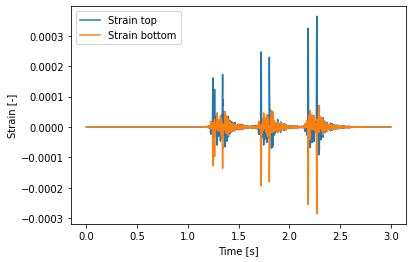

In [31]:

plt.plot(coupled_model.time, strains)

plt.xlabel('Time [s]')
plt.ylabel('Strain [-]')
plt.legend(['Strain top', 'Strain bottom'])
plt.show()